![banner](/custom/banner.png)


# FSLeyes Jupyter notebook


## Help


Use the built-in `help` function to get help on anything in the shell
environment, whether it is a module, function, class, or object:

    help(load)



## Overlays


The `overlayList` is a list which contains all of the overlays that have been
loaded into FSLeyes.  You can load overlays by using the `load` function,
e.g.:

    std = load('MNI152_T1_2mm.nii.gz')


You can remove an overlay simply by removing it from the `overlayList`:

    del overlayList[0]


## Display settings


You can use the `displayCtx` to access the display settings for an
overlay. Display settings for an overlay are divided between two objects:

 - A `Display` object, which contains general display settings
 - A `DisplayOpts` object, which contains display settings specific to the
   overlay type


You can access these objects like so:

    overlay = overlayList[0]
    display = displayCtx.getDisplay(overlay)
    opts    = displayCtx.getOpts(   overlay)


Then adjusting the overlay display settings is easy:


    display.brightness = 75
    opts.cmap          = 'hot'


## FSL commands


Many FSL commands can be called through Python functions, e.g.:

    flirt('src.nii.gz', 'ref.nii.gz', applyxfm=True, init='src2ref.mat')


For commands which produce output images, you can have the outputs loaded
directly into FSLeyes by using the special `LOAD` symbol:

    struc = Image('struct.nii.gz')
    bet(struc, LOAD)


To submit a command as a cluster job, use the `submit` flag:

    fnirt('src.nii.gz', 'ref.nii.gz', submit=True)


## User interface


You can access the current views in FSLeyes through the ``frame`` object:

    ortho = frame.viewPanels[0]


You also can add/remove views through the ``frame``:


    frame.removeViewPanel(ortho)
    frame.addViewPanel(Scene3DPanel)


## Screenshots


To insert a screenshot of the currently displayed scene into the notebook, use
the `screenshot` function:

    ortho = frame.viewPanels[0]
    screenshot(ortho)


## Reproducing a scene


The `getState` function returns a string which describes the current FSLeyes
state. This string describes the current FSLeyes user interface (views,
controls, and toolbars) as well as all loaded overlays and their display
settings.


You can also use the `setState` function to reproduce a previously generated
FSLeyes state.


To make your notebook reproduce your FSLeyes setup, set up your user interface
and overlays how you want, and then call `getState` to get a description of
the current FSLeyes setup:


    getState()


Now copy the string that `getState` generates, and then at the top of your
notebook add a call to `setState`, passing in that string, e.g.:

    fsleyesState = 'OrthoPanel\nlayout2|name=OrthoPanel 1;caption=...'
    setState(fsleyesState)


## For more information

See the FSLeyes and `fslpy` API documentation:

 - https://open.win.ox.ac.uk/pages/fsl/fsleyes/fsleyes/apidoc/
 - https://open.win.ox.ac.uk/pages/fsl/fslpy/

### 1. Load data and visualization

In [1]:
# General purpose imports to handle paths, files etc
import os
import os.path as op
import glob
import pandas as pd
import numpy as np
import json


# Useful functions to define and import datasets from open neuro
import openneuro
from mne.datasets import sample
from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

# Useful imports to define the direct download function below
import requests
import urllib.request
from tqdm import tqdm


# # FSL function wrappers which we will call from python directly
# from fsl.wrappers import fast, bet
# from fsl.wrappers.misc import fslroi
# from fsl.wrappers import flirt



# def reset_overlays():
#     """
#     Clears view and completely remove visualization. All files opened in FSLeyes are closed.
#     The view (along with any color map) is reset to the regular ortho panel.
#     """
#     l = frame.overlayList
#     while(len(l)>0):
#         del l[0]
#     frame.removeViewPanel(frame.viewPanels[0])
#     # Put back an ortho panel in our viz for future displays
#     frame.addViewPanel(OrthoPanel)
    
def mkdir_no_exist(path):
    if not op.isdir(path):
        os.makedirs(path)
        
def get_json_from_file(fname):
    f = open(fname)
    data = json.load(f)
    f.close()
    return data

c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
!pip install tqdm
!pip install fury
!pip install nibabel
!pip install nistats
!pip install nilearn
!pip install tensorly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.8/510.8 kB 12.2 MB/s eta 0:00:00 MB/s eta 0:00:01
  Obtaining dependency information for aiohttp>=3.8.4 from https://files.pythonhosted.org/packages/34/97/d042349afcad79d7c813b07e34cb3a6f0024b4faf07346509b115fe19f97/aiohttp-3.8.6-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.3/79.3 MB 22.6 MB/s eta 0:00:00m eta 0:00:010:01:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 29.5 MB/s eta 0:00:00
  Obtaining dependency information for async-timeout<5.0,>=4.0.0a3 from https://files.pythonhosted.org/packages/a7/fa/e01228c2938de91d47b307831c62ab9e4001e747789d0b05baf779a6488c/async_timeout-4.0.3-py3-none-any.whl.metadata
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 39.3 MB/s eta 0:00:00
  Obtaining dependency information for frozenl

In [2]:
import os
from tqdm.notebook import trange, tqdm
import numpy as np
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
from nilearn.image import iter_img
from nilearn.plotting import plot_stat_map, show
from sklearn.decomposition import FastICA, PCA

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from scipy.stats import zscore
from scipy.io import loadmat
from tensorly.decomposition import parafac
from IPython.display import Image

save_results = 'results/'
if not os.path.exists(save_results):
    os.makedirs(save_results)
    
%matplotlib inline

c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\input_data\__init__.py:23: FutureWarning: The import path 'nilearn.input_data' is deprecated in version 0.9. Importing from 'nilearn.input_data' will be possible at least until release 0.13.0. Please import from 'nilearn.maskers' instead.
  warnings.warn(message, FutureWarning)


Download the dataset: https://drive.google.com/drive/folders/1qbu13FhPI0WxrBMDLyt2WRxWIc6gXmaS

### If data in MyFiles

In [3]:
#loading the data
subject = '02' 


In [4]:
import nibabel as nib
%matplotlib inline

def load_func_data(subject, run) :
    bids_root = op.join(os.path.abspath(""), "miniproject_icafunc_bold")
    deriv_root = op.join(bids_root, 'derivatives')
    func_path = op.join(deriv_root, 'sub-'+ subject, 'func')
    file_name = "sub-" + subject + "_task-fullchecker_run-" + run + "_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    return op.join(func_path, file_name) 
    
def load_event(subject, run) :
    bids_root = op.join(os.path.abspath(""), "miniproject_ica_events")
    func_path = op.join(bids_root, 'sub-'+subject, 'func')
    file_name = "sub-" + subject + "_task-fullchecker_run-" + run + "_events.tsv"
    return op.join(func_path, file_name) 
    
def load_anat_data(subject) :
    sample_path = "miniproject_ica_data_anat"
    bids_root = op.join(os.path.abspath(""), sample_path)
    deriv_root = op.join(bids_root, 'derivatives')
    anat_path = op.join(deriv_root, 'sub-'+ subject, 'anat')
    file_name = "sub-"+ subject + "_run-001_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
    return op.join(anat_path, file_name)
    

def load_data(path:str) -> np.ndarray :
    img = nib.load(path)
    data = np.asanyarray(img.dataobj)
    return data

def load_data_event(event_path):
    return pd.read_csv(event_path, sep='\t')

def plot_anat(data : np.ndarray, title, slice : int = None) -> None : 
    
    sub_title = ["sagittal view", "coronal view", "axial view" ]


    fig, ax = plt.subplots(1,3, figsize=(9, 3))
    fig.tight_layout()
    for i, ax in enumerate(ax):
        if slice == None :
            s = int(data.shape[i]/2)
        else :
            s = slice
        ax.imshow(np.rot90(data.take(s,axis=i)), cmap="gray", aspect="auto")
        ax.set_title(sub_title[i])
    fig.suptitle(title, x=0.5, y=1.2)
    plt.show()


def load_json(subject, run):
    bids_root = op.join(os.path.abspath(""), "miniproject_icafunc_bold")
    func_path = op.join(bids_root, 'derivatives', 'sub-'+subject, 'func')
    sub_json = op.join(func_path, 'sub-'+subject+'_task-fullchecker_run-'+run + '_space-MNI152NLin2009cAsym_desc-preproc_bold.json')
    return sub_json

### If not enough space in MyFiles, run rather the cell bellow:

In [3]:
# Path to downloads
downloads_path = str(Path.home() / "Downloads")

#loading the data
subject = '02' 

# load each data
sample_path2 = "miniproject_ica_events"
sample_path3 = "miniproject_icafunc_bold"
bids_root2 = op.join(downloads_path, sample_path2)
bids_root3 = op.join(downloads_path, sample_path3)
deriv_root3 = op.join(bids_root3, 'derivatives')

# event data file
func_path1 = op.join(bids_root2, 'sub-'+subject, 'func')
print(func_path1)

# functional MRI data
func_path2 = op.join(deriv_root3, 'sub-'+subject, 'func')
print(func_path2)


/home/cfriedri/Downloads/miniproject_ica_events/sub-02/func
/home/cfriedri/Downloads/miniproject_icafunc_bold/derivatives/sub-02/func


In [4]:
import nibabel as nib
%matplotlib inline

# get the path of the functional data of one single subject
def load_func_data(subject, run) :
    bids_root = op.join(downloads_path, "miniproject_icafunc_bold")
    deriv_root = op.join(bids_root3, 'derivatives')
    func_path = op.join(deriv_root, 'sub-'+ subject, 'func')
    file_name = "sub-" + subject + "_task-fullchecker_run-" + run + "_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    return op.join(func_path, file_name) 

# get the path of the event data for one single subject
def load_event(subject, run) :
    bids_root = op.join(downloads_path, "miniproject_ica_events")
    func_path = op.join(bids_root, 'sub-'+subject, 'func')
    file_name = "sub-" + subject + "_task-fullchecker_run-" + run + "_events.tsv"
    return op.join(func_path, file_name)

def load_json(subject, run):
    bids_root = op.join(downloads_path, "miniproject_icafunc_bold")
    func_path = op.join(bids_root, 'derivatives', 'sub-'+subject, 'func')
    sub_json = op.join(func_path, 'sub-'+subject+'_task-fullchecker_run-'+run + '_space-MNI152NLin2009cAsym_desc-preproc_bold.json')
    return sub_json

# get the path of the anatomical data of one single subject for one run
def load_anat_data(subject) :
    sample_path = "miniproject_ica_data_anat"
    bids_root = op.join(downloads_path, sample_path)
    deriv_root = op.join(bids_root, 'derivatives')
    anat_path = op.join(deriv_root, 'sub-'+ subject, 'anat')
    file_name = "sub-"+ subject + "_run-001_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz"
    return op.join(anat_path, file_name)
    
# get the data in the right format
def load_data(path:str) -> np.ndarray :
    img = nib.load(path)
    data = np.asanyarray(img.dataobj)
    return data

# load the event files as pandas
def load_data_event(event_path):
    return pd.read_table(event_path)


# plot the anatomical images in the notebook
def plot_anat(data : np.ndarray, title, slice : int = None) -> None : 
    
    sub_title = ["sagittal view", "coronal view", "axial view" ]


    fig, ax = plt.subplots(1,3, figsize=(9, 3))
    fig.tight_layout()
    for i, ax in enumerate(ax):
        if slice == None :
            s = int(data.shape[i]/2)
        else :
            s = slice
        ax.imshow(np.rot90(data.take(s,axis=i)), cmap="gray", aspect="auto")
        ax.set_title(sub_title[i])
    fig.suptitle(title, x=0.5, y=1.2)
    plt.show()

### Visualize anatomical data from several subjects

In [5]:
anat_sub_02_path = load_anat_data(subject)
anat_sub_02 = load_data(anat_sub_02_path)

In [5]:
reset_overlays()
load(anat_sub_02_path)

Image(sub-02_run-001_space-MNI152NLin2009cAsym_desc-preproc_T1w, /home/cfriedri/Downloads/miniproject_ica_data_anat/derivatives/sub-02/anat/sub-02_run-001_space-MNI152NLin2009cAsym_desc-preproc_T1w.nii.gz)

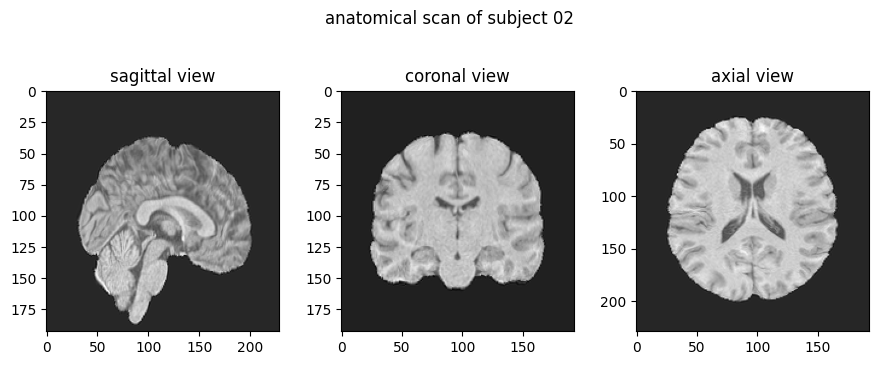

In [6]:
plot_anat(anat_sub_02, "anatomical scan of subject 02")

In [20]:
anat_sub_05_path = load_anat_data("05")
load(anat_sub_05_path)

NameError: name 'load' is not defined

By visualizing all anatomical images on FSL we conclude that all 10 subject are anatomically aligned.

### Visualize functional data from the 10 subjects

In [7]:
func_sub_02_path = load_func_data(subject, "001")
func_sub_02 = load_data(func_sub_02_path)

In [37]:
func_sub_02.shape

(66, 78, 65, 242)

In [7]:
reset_overlays()
load(func_sub_02_path)

Image(sub-02_task-fullchecker_run-001_space-MNI152NLin2009cAsym_desc-preproc_bold, /home/cfriedri/Downloads/miniproject_icafunc_bold/derivatives/sub-02/func/sub-02_task-fullchecker_run-001_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz)

In [8]:
func_sub_13_path = load_func_data("13", "001")
load(func_sub_13_path)

Image(sub-13_task-fullchecker_run-001_space-MNI152NLin2009cAsym_desc-preproc_bold, /home/cfriedri/Downloads/miniproject_icafunc_bold/derivatives/sub-13/func/sub-13_task-fullchecker_run-001_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz)

Again by looking at the functional data on FSL we see that the all functional volumes are properly aligned. The preprocessing has been done properly!

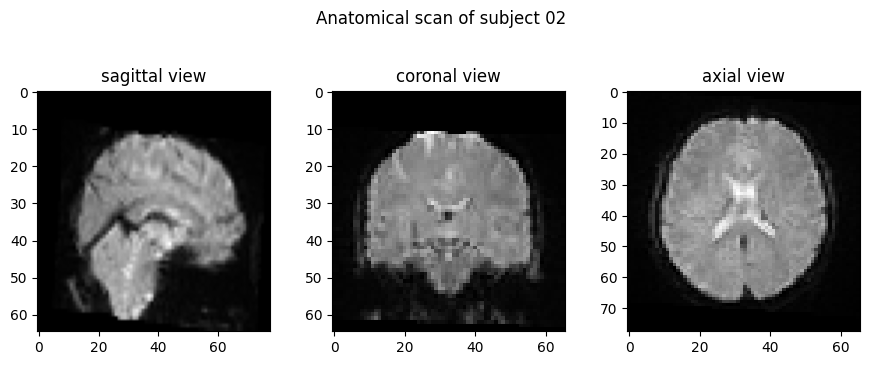

In [8]:
plot_anat(func_sub_02[:,:,:,121], "Anatomical scan of subject 02")

Shape of the funcitonal data:

In [9]:
func_sub_16_path = load_func_data("16", "001")
func_sub_16 = load_data(func_sub_16_path)
func_sub_16.shape

(66, 78, 65, 242)

In [39]:
# for later
66*78*65*242

80978040

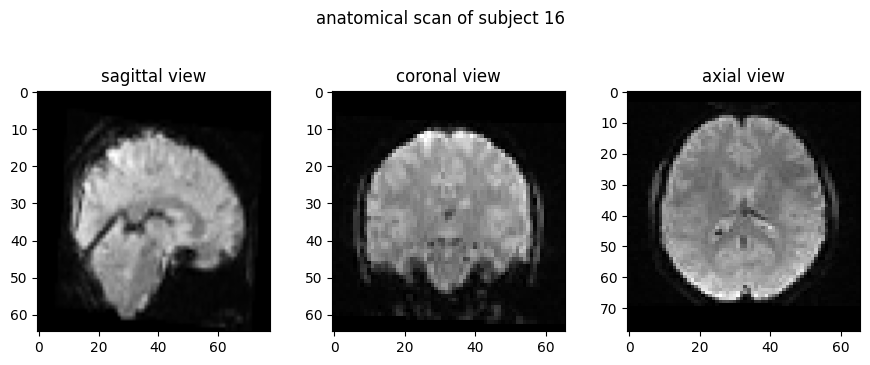

In [10]:
plot_anat(func_sub_16[:,:,:,121], "anatomical scan of subject 16")

### Visualize the event files (design matrices)

In [11]:
from nilearn.plotting import plot_event

In [12]:
event_sub_02_path = load_event(subject, "001")
event_sub_02 = load_data_event(event_sub_02_path)

new_events_sub_02 = event_sub_02[["trail_type", "onset", "duration"]]
new_events_sub_02 = new_events_sub_02.rename(columns={"trail_type": "trial_type"})
new_events_sub_02

,trial_type,onset,duration
0,full_circular_checkerboard,0,120
1,white_fixation,120,16
2,full_circular_checkerboard,136,32
3,white_fixation,168,16
4,full_circular_checkerboard,184,32
5,white_fixation,216,16
6,full_circular_checkerboard,232,32
7,white_fixation,264,16
8,full_circular_checkerboard,280,32
9,white_fixation,312,16


In [16]:
new_events_sub_02

trial_type    object
onset          int64
duration       int64
dtype: object

In [53]:
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=7,
                           noise_model='ar1',
                           standardize=False,
                           hrf_model='spm',
                           drift_model=None,
                           high_pass=.01)

path_func_img = func_sub_02_path
img_ex = nib.load(path_func_img)


# Fit the model to our design and data
fmri_glm = fmri_glm.fit(img_ex, new_events_sub_02)

from nilearn.glm.first_level import FirstLevelModel

# Specify what sort of GLM we want (nature of the noise, repetition time of the data and other parameters)
fmri_glm = FirstLevelModel(t_r=2.5,
                           drift_model=None)

path_func_img = func_sub_02_path
img_ex = nib.load(path_func_img)


# Fit the model to our design and data
fmri_glm = fmri_glm.fit(img_ex, new_events_sub_02)

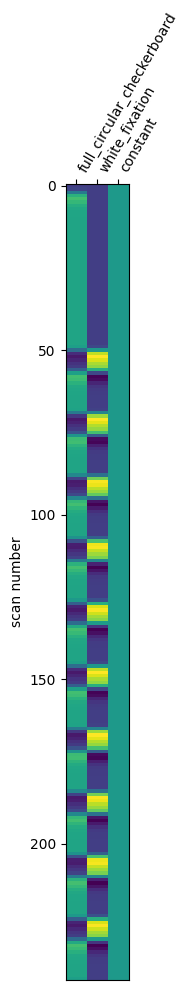

In [54]:
from nilearn.plotting import plot_design_matrix
plot_design_matrix(fmri_glm.design_matrices_[0])
plt.show()

In [31]:
sub_02_json_path = load_json('02', '001')
data_json = get_json_from_file(sub_02_json_path)
data_json

{'DelayTime': 2.44877,
 'RepetitionTime': 2.45,
 'SkullStripped': False,
 'SliceTimingCorrected': True,
 'StartTime': 0.001,
 'TaskName': 'fullchecker'}

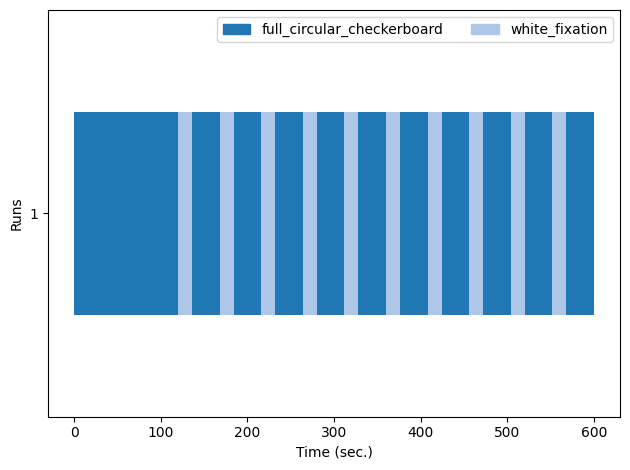

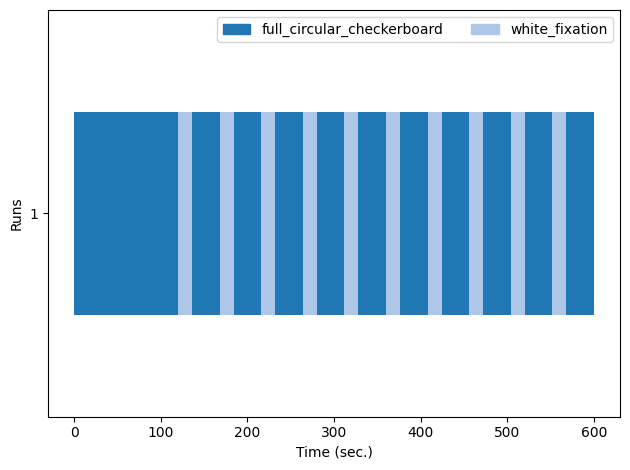

In [32]:
plot_event(new_events_sub_02)

### 2) Apply group ICA 

We want to apply group ICA on the dataset by concatenating sessions together. Make sure to standardize each session before concatenation!

In [31]:
bids_root = op.join(os.path.abspath(""), "miniproject_icafunc_bold")
deriv_root = op.join(bids_root, 'derivatives')

#### If the data is in MyFiles run the following instead

In [7]:
bids_root = op.join(downloads_path, "miniproject_icafunc_bold", "derivatives")
path_ICA_data = op.join(bids_root, 'sub-'+subject)
print(path_ICA_data)

/home/cfriedri/Downloads/miniproject_icafunc_bold/derivatives/sub-02


In [ ]:
# Prepare data

path_func_img = func_sub_02_path
img_ex = nib.load(path_func_img)

# Get affine transform -- check nibabel library for more info!
affine = nib.load(path_func_img).affine
x,y,z,v = img_ex.shape
print(x,y,z,v)

N_vol=242
N_subj=1
N_tot=N_vol*N_subj

#* Initialize X
size = x*y*z
X_data = np.zeros((N_tot,size)) # total_timepoints(2subj*242timepoints) x voxel_num
i = 0
n_nii  = 0
nb_subj_counted=0
for root, dirs, files in sorted(os.walk(deriv_root)):
    print(files)
    if len(files)!= 0:
        nb_subj_counted=nb_subj_counted+1 
        print(f"Loading subject {nb_subj_counted}")
    for j in range(len(files)):
        file = sorted(files)[j]
        if file.endswith('.nii.gz') and file.partition("run-")[2][0:3] == "001": # do we need to do it for all run ??
            if nb_subj_counted<N_subj+1:
                print("file",file)
                
                data = nib.load(root+'/'+file).get_fdata().reshape(size, -1).T
                
                #standardize
                row_means = np.mean(data, axis=1).reshape(-1,1)
                row_std = np.std( data, axis = 1).reshape(-1,1)
                data= data - row_means / row_std

                X_data[n_nii : n_nii + N_vol, :] = data
                n_nii+=N_vol
                print(n_nii)

X_data = zscore(X_data, axis = 1) # across subjects
X_data = np.nan_to_num(X_data,0) # nan to 0s
print("X matrix size: ", X_data.shape)


In [75]:
np.where(np.mean(X_data, axis = 1)  == 10**-15) #verify normalisation

(array([], dtype=int64),)

In [89]:
S_dict = {}

# assign the variable nb_components to bes the list of components (try 3-5 values )

nb_components =  [4,10]#20, 60 ...]


for n in nb_components:
    print(f"Processing component {n}")
    
    # Reminder: Fast ICA model S = X W
    print("Running FastICA with n = %d components" %n)
    ### BEGIN SOLUTION
    ica = FastICA(n_components=n, random_state=1, max_iter=200)
    S_ = ica.fit_transform(X_data.T)  # Get the estimated sources (S)
    ### END SOLUTION
    print(S_.shape)
    W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
    S_dict[n] = S_ # store the results in a dictionary

    print("Done")

Processing component 4
Running FastICA with n = 4 components
(334620, 4)
Done
Processing component 10
Running FastICA with n = 10 components
(334620, 10)
Done


In [48]:
print("The shape of the estimated Sources is: {}".format(S_.shape))

The shape of the estimated Sources is: (334620, 10)


### 3- Visualization

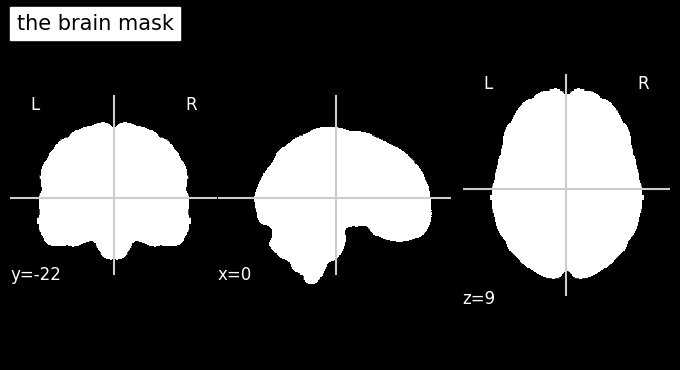

In [90]:
#* mask too big cannot use it before ica : find another one or create one with our data
icbms = datasets.fetch_icbm152_2009() 
masker = NiftiMasker(mask_img=icbms.mask)
plot_stat_map(icbms.mask, black_bg=True, title='the brain mask', colorbar=False,)

In [91]:
print(affine)
bg = nib.load(anat_sub_02_path)
print(bg.shape)

[[   2.9690001    0.           0.         -96.5      ]
 [   0.           2.9690001    0.        -132.5      ]
 [   0.           0.           3.         -78.5      ]
 [   0.           0.           0.           1.       ]]
(193, 229, 193)


Number of components:  4
(66, 78, 65)


c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


(197, 233, 189, 1)


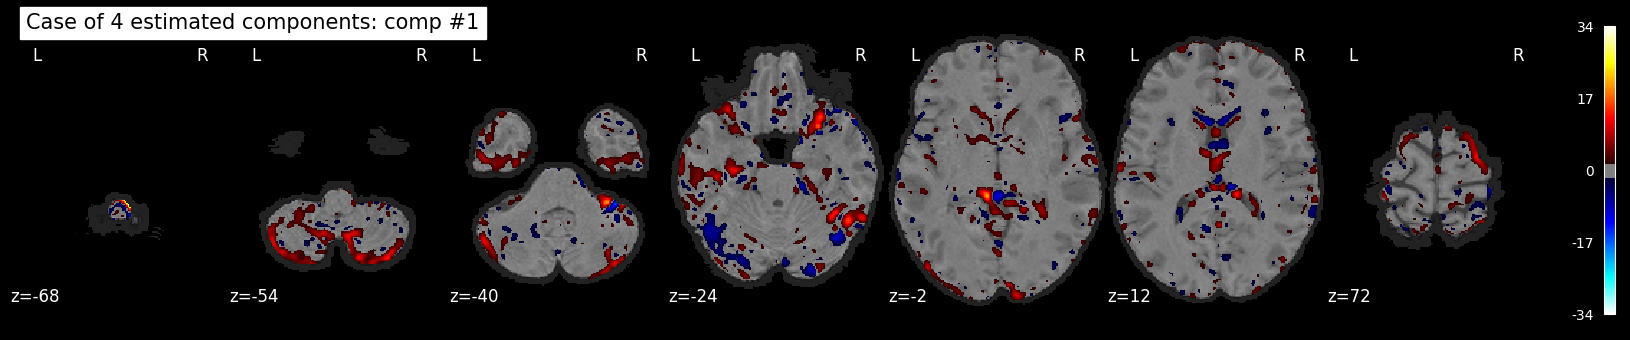

(66, 78, 65)


c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


(197, 233, 189, 1)


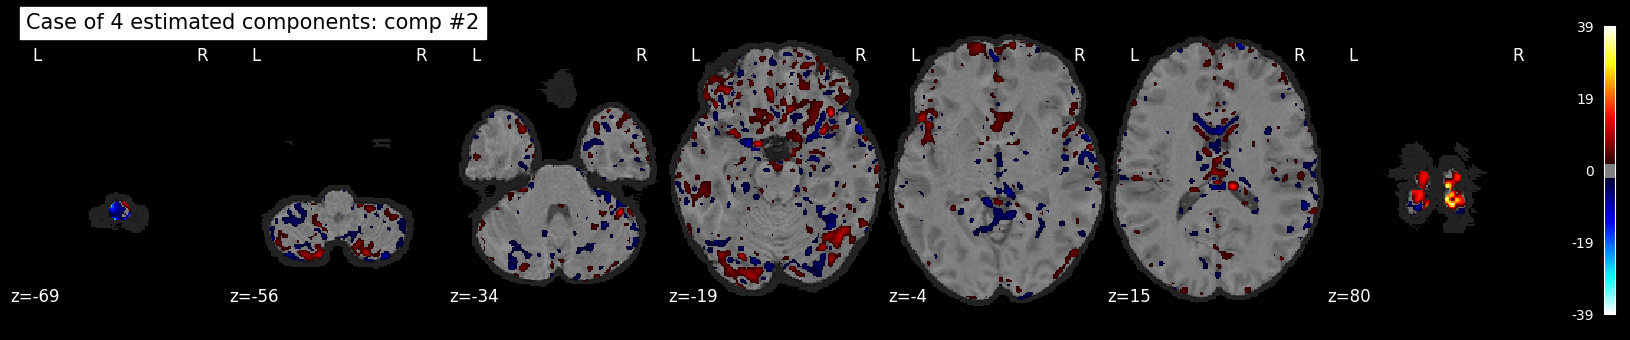

(66, 78, 65)


c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


(197, 233, 189, 1)


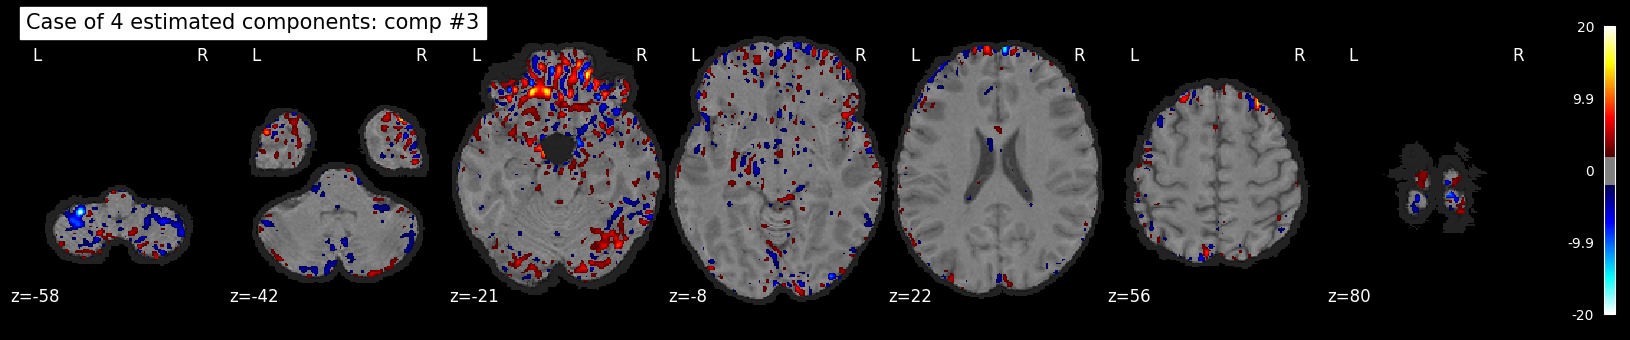

(66, 78, 65)


c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:108: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(


(197, 233, 189, 1)


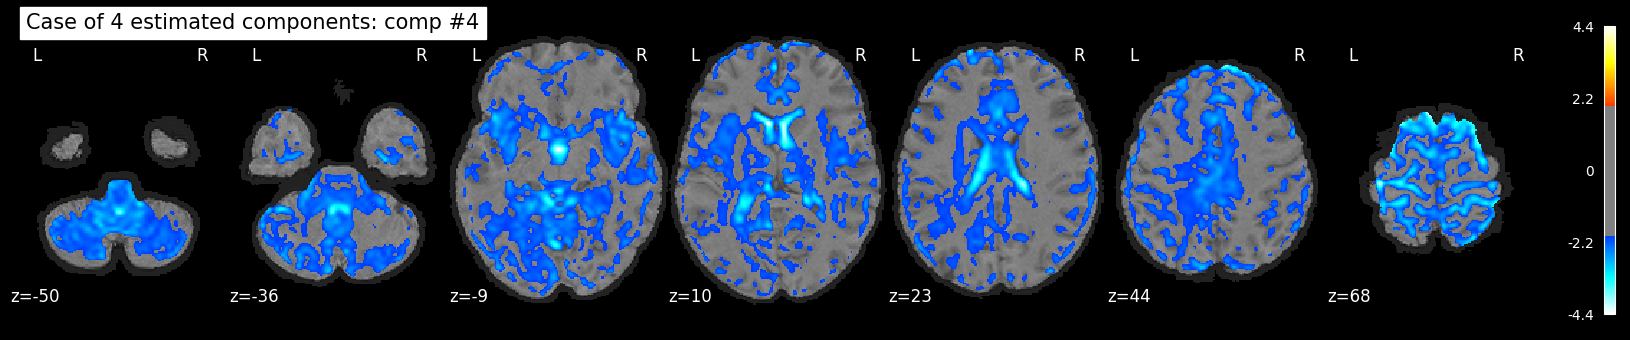

In [95]:
def ICA_plot (nb_components, data_dict, mask) :

    for n in nb_components[0:1]:
        print('Number of components: ', n)
        S_ = data_dict[n].copy()
        for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components , change 10 with 4 to plot less
            s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
            print(s_img.shape)
            data = mask.fit_transform(s_img)
            masked_ = masker.inverse_transform(data) # mask the components
            print(masked_.shape)
            plot_stat_map(masked_, display_mode="z", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                          colorbar=True, black_bg=True, threshold=2*np.std(s), bg_img=bg,)
                          #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
            plt.show()

ICA_plot(nb_components, S_dict, masker)

In [ ]:
#* Not needed 
for n in nb_components:
    print('Number of components: ',n)
    S_ = S_dict[n].copy()
    for idx, s in enumerate(S_.T[:min(10, S_.T.shape[0]),:]): # plot min(4, #comp_estimated) components
        s_img = nib.Nifti1Image(np.reshape(s, (x,y,z)), affine)
        data = masker.fit_transform(s_img)
        masked_ = masker.inverse_transform(data) # mask the components
        plot_stat_map(masked_, display_mode="ortho", title='Case of {} estimated components: comp #{}'.format(n,idx+1),
                      colorbar=True, black_bg=True, threshold=2*np.std(s))
                      #output_file=save_results + "ICA_components_{}_n_{}.png".format(idx,n)) # uncomment to save plot
        plt.show()

Try using a mask that erase pixel out of the brain : 

In [67]:
masker = NiftiMasker(
    smoothing_fwhm=8,
    memory="nilearn_cache",
    memory_level=1,
    mask_strategy="epi",
    standardize="zscore_sample",
)
d = nib.load(func_sub_02_path)
data_masked = masker.fit_transform(d)

c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:439: UserWarning: Persisting input arguments took 1.03s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  self.mask_img_ = self._cache(compute_mask, ignore=["verbose"])(
c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\nilearn\maskers\nifti_masker.py:558: UserWarning: Persisting input arguments took 1.07s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  data = self._cache(


In [73]:
data_masked.shape

(242, 63693)

In [68]:
from sklearn.decomposition import FastICA

n_components = 10
ica = FastICA(n_components=n_components, random_state=42)
components_masked = ica.fit_transform(data_masked.T).T

# Normalize estimated components, for thresholding to make sense
components_masked -= components_masked.mean(axis=0)
components_masked /= components_masked.std(axis=0)

# Threshold
import numpy as np

components_masked[np.abs(components_masked) < 0.8] = 0

# Now invert the masking operation, going back to a full 3D
# representation
component_img = masker.inverse_transform(components_masked)

c:\Users\camil\miniconda3\envs\nssp\Lib\site-packages\sklearn\decomposition\_fastica.py:128: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  warnings.warn(


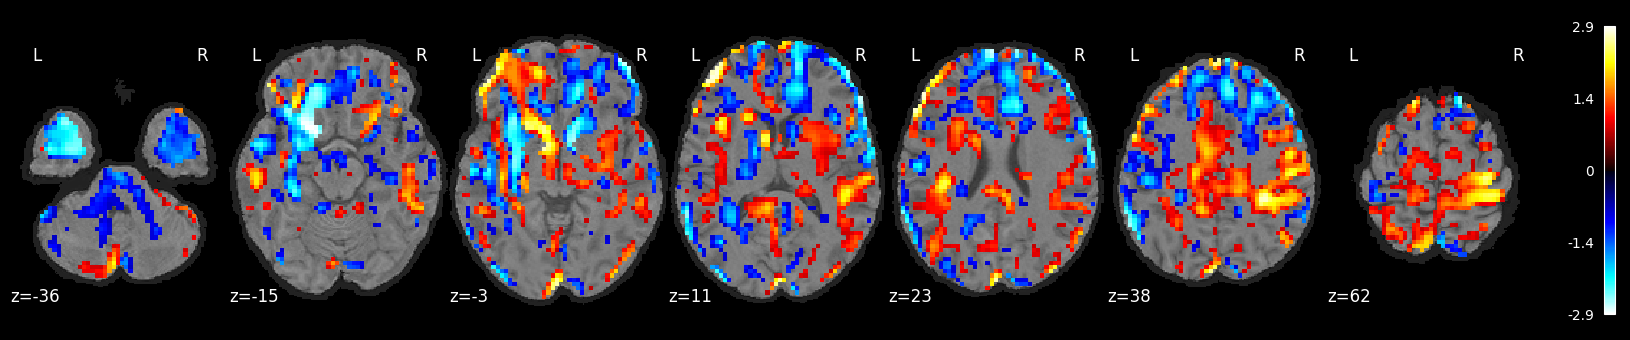

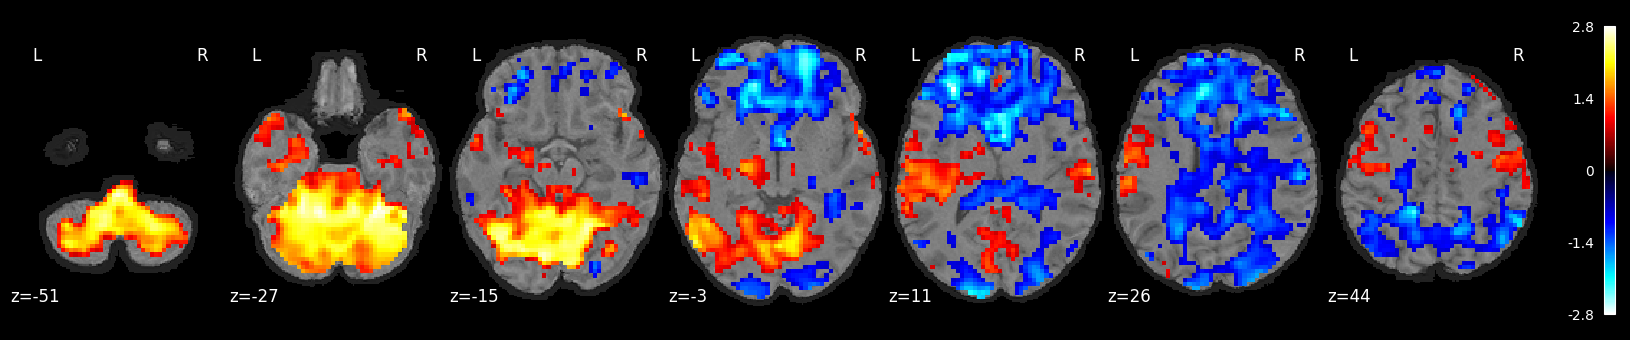

In [83]:
from nilearn import image
from nilearn.plotting import plot_stat_map, show

# Show some interesting components

# Use the mean as a background
mean_img = image.mean_img(d)

plot_stat_map(image.index_img(component_img, 0),  bg_img=bg, display_mode="z")

plot_stat_map(image.index_img(component_img, 1),  bg_img=bg, display_mode="z")

show()

work well ! seems that we can distinguish the visual area in the 2nd component. But as it keep not the same shape for each subject, cant use it for more than one fmri. Try using a bet mask before ICA ?

### 4- TImeCourse

In [ ]:
# Let's visualize the corresponding timecourses when nb_comp=...

timecourse_dict = {}
# As was done in the above visualization, we are interested in voxels above 2 standard deviations
for nbcomp in nb_components :
    associated_timecourses = []
    S_ = S_dict[nbcomp].copy()
    print(f"The number of components you visualize are {nbcomp}")
    for cidx in range(nbcomp):
        threshold = np.std(S_[:,cidx])
        s_comp = np.reshape(S_[:,cidx], (x,y,z))
        thresh_mask = s_comp > threshold

        # Original timecourse - prior to PCA which we used to simplify spatial patterns
        t_comp = X_data.reshape(N_tot, x,y,z)[:,thresh_mask].mean(axis=1) # Averaging voxel-wise for a single representative timecourse
        associated_timecourses.append(t_comp)
    timecourse_dict[nbcomp] = associated_timecourses



4
The number of components you visualize are 4
10
The number of components you visualize are 10


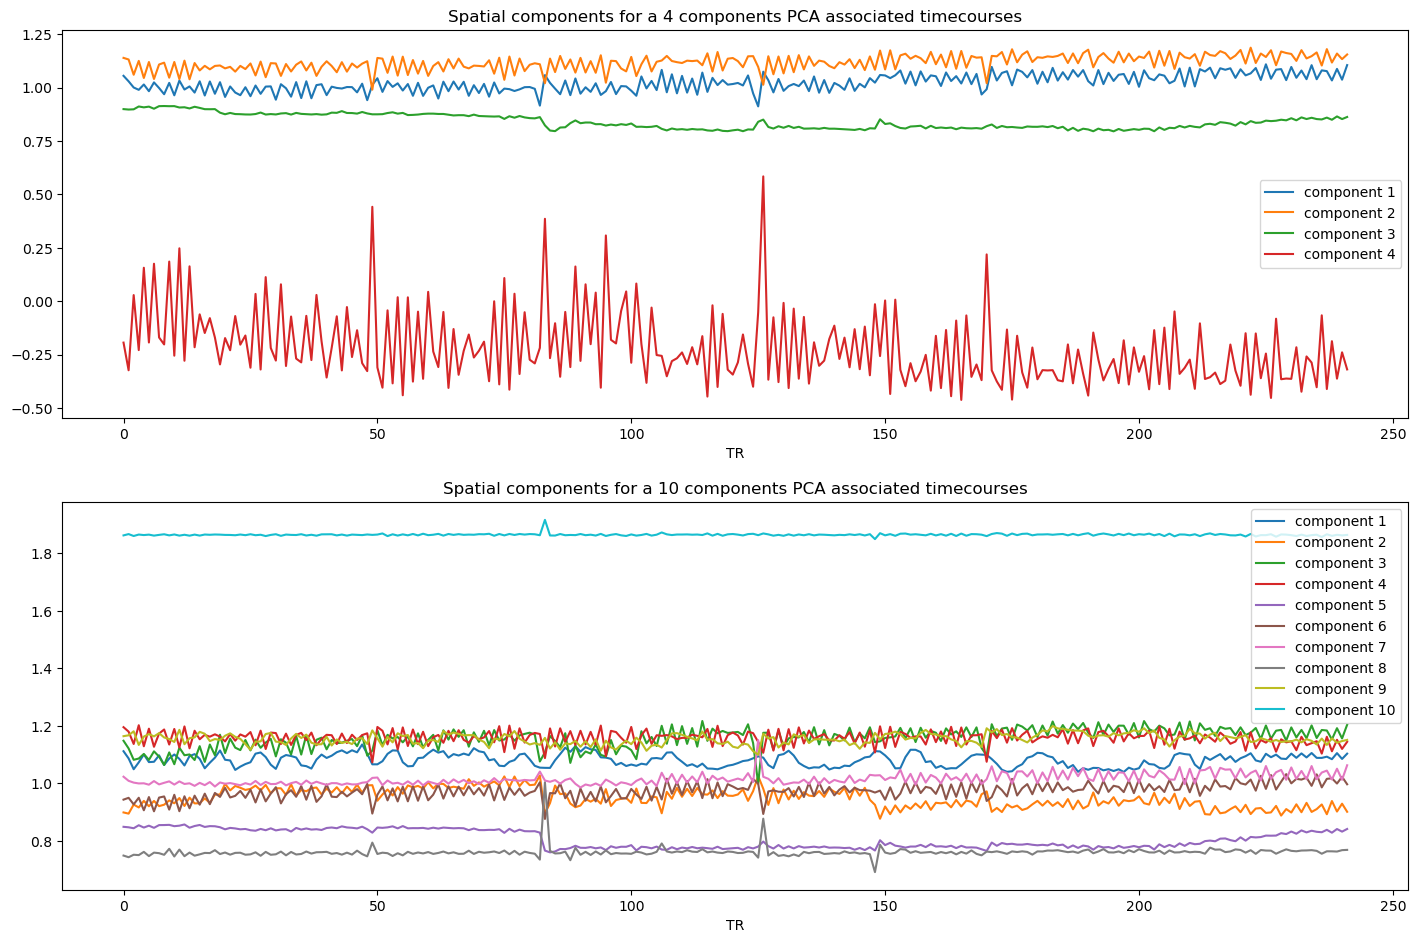

In [64]:
fig, ax = plt.subplots(2, figsize=(15,10))
fig.tight_layout(pad=4.0)

for i, nbcomp in enumerate(nb_components) : 
    assoc_timecourses = timecourse_dict[nbcomp]
    for cidx in range(nbcomp):
        ax[i].plot(assoc_timecourses[cidx], label=f'component {cidx+1}')

        ax[i].legend()
        ax[i].set_xlabel('TR')
        ax[i].set_title(f'Spatial components for a {nbcomp} components PCA associated timecourses')
plt.show()


In [ ]:
# How to interpret these graph ? What are the axis ?

### 5- PCA

### Load the Data

In [11]:
subject = '02' 
pca_path_func_data = load_func_data(subject, "001")
img = nib.load(pca_path_func_data)
data_pca = np.asanyarray(img.dataobj)
data_pca.shape

(66, 78, 65, 242)

In [12]:
vol_shape = data_pca.shape[:-1]
n_vols = data_pca.shape[-1]
vol_shape = data_pca.shape[:-1]
print(vol_shape, n_vols)

In [13]:
N = np.prod(vol_shape)
data_pca = data_pca.reshape((N, n_vols))
# Transpose to 242 by N array
data_pca = data_pca.T
# Calculate the mean across columns
row_means = np.mean(data_pca, axis=1)
# Row means copied N times to become a 2 by N array
row_means = np.outer(row_means, np.ones(N))
# Subtract the means for each row, put the result into X
X = data_pca - row_means
print(X.shape)

(242, 334620)


In [20]:
# Compute the covariance matrix 
covariance_matrix = X.dot(X.T)

# Apply SVD to get U, S, VT matrices from covariance matrix
U, S, VT = np.linalg.svd(covariance_matrix)
print(U.shape)
print(n_vols)

(242, 242)
242


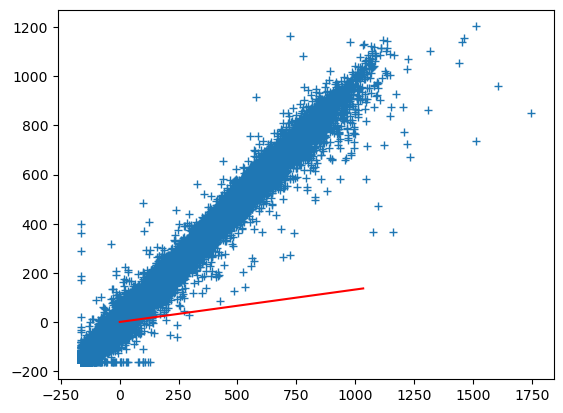

In [15]:
# Plot line corresponding to a scaled version of the first principal component
plt.plot(X[0], X[1], '+')
scaled_u = U[0, :] * -16000
plt.plot([0, scaled_u[0]], [0, scaled_u[1]], 'r')

In [16]:
C = U.T.dot(data_pca)
C.shape

(242, 334620)

In [17]:
# Transpose C
# Reshape the first dimension of C to have the 3D shape of the original data volumes.
C_vols = C.T.reshape(vol_shape + (n_vols,))
C_vols.shape

#- Break 4D array into two 3D volumes
vol0 = C_vols[..., 0]
vol1 = C_vols[..., 1]

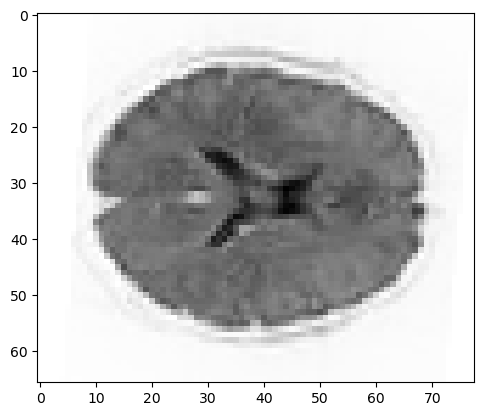

In [18]:
plt.imshow(vol0[:, :, 32], cmap='gray')

In [57]:
def PCA_defined_variance(U, data_pca, threshold):
    # #calculate the number of eigenvectors needed to explain chosen variance
    # num_eigenvectors = int(np.floor(U.shape[1] * threshold))
    # print(num_eigenvectors)
  
    eigenvalues = S.diagonal()**2
    sum_eig = eigenvalues.sum()
    explained_variance = 0
    num_eigenvectors = 0
    for eigenvalue in eigenvalues:
        variance = eigenvalue/sum_eig
        num_eigenvectors +=1
        explained_variance = explained_variance + variance
        if explained_variance >= threshold :
            break

     
    U_less_variance = U[:, :num_eigenvectors]
    print(U_less_variance.shape)
    C = U_less_variance.T.dot(data_pca)
    print(C.shape)

    # Transpose C
    # Reshape the first dimension of C to have the 3D shape of the original data volumes.
    C_vols = C.T.reshape(vol_shape + (num_eigenvectors,))
    C_vols.shape

    #- Break 4D array into two 3D volumes
    vol0 = C_vols[..., 0]
    vol1 = C_vols[..., 1]
    plt.imshow(vol0[:, :, 32], cmap='gray')
    
    

#### Apply PCA for 25 % Variance explained

60
(242, 60)
(60, 334620)


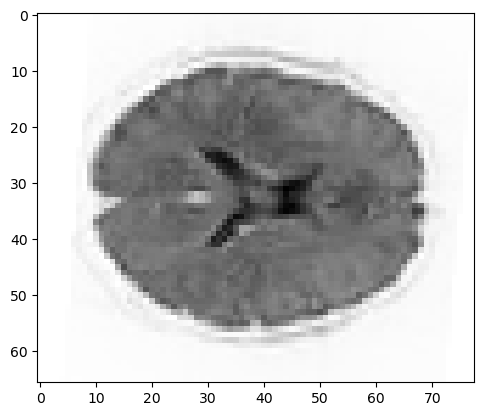

In [58]:
PCA_defined_variance(U, data_pca, 0.25)

#### Apply PCA for 50% Variance explained

121
(242, 121)
(121, 334620)


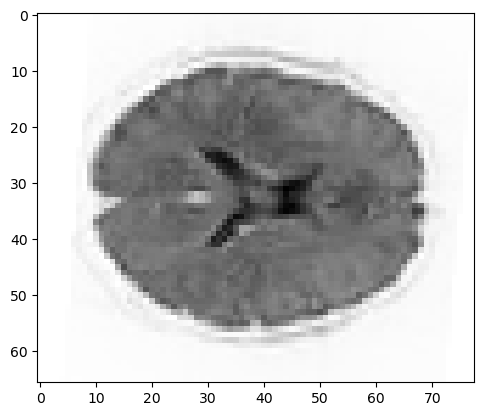

In [59]:
PCA_defined_variance(U, data_pca, 0.5)

#### Apply PCA for 95% Variance explained

229
(242, 229)
(229, 334620)


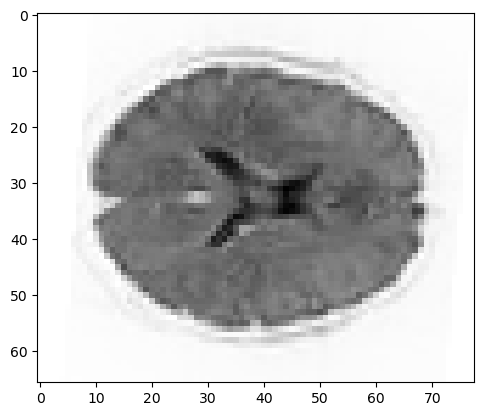

In [60]:
PCA_defined_variance(U, data_pca, 0.95)

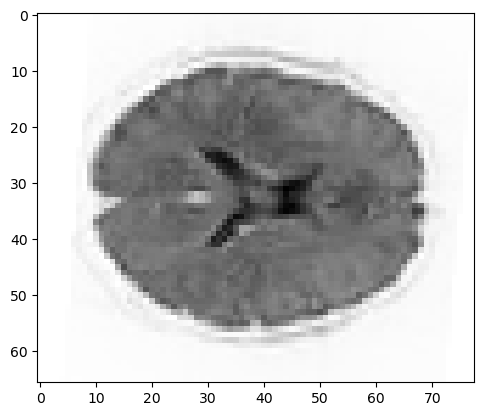

In [ ]:
# are we not supposed to do an ICA with a PCA like that ? :

In [ ]:
import scikitplot as skplt
pca = PCA(random_state=1)
pca.fit(X_data.T)
skplt.decomposition.plot_pca_component_variance(pca)
plt.show()

In [ ]:
# plot bizarre ..... une pca de 25%, 50% et 75% de la variance prendrait tous que le 1er component

In [ ]:
pca = PCA()

X_train_pca = pca.fit_transform(X_data.T)
#
# Determine explained variance using explained_variance_ration_ attribute
#
exp_var_pca = pca.explained_variance_ratio_
#
# Cumulative sum of eigenvalues; This will be used to create step plot
# for visualizing the variance explained by each principal component.
#
cum_sum_eigenvalues = np.cumsum(exp_var_pca)
#
# Create the visualization plot
#
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

#Pk il est moche le plot ?

In [ ]:
#* Run FastICA with PCA 25 % variance

S_dict = {}

# assign the variable nb_components to be the list of components (try 3-5 values )

nb_components =  [4,10]#20, 60 ...]


for n in nb_components:
    print(f"Processing component {n}")
    
    # run PCA as a preprocessing step for ICA with twice the number of components
    n2=2*n
    pca = PCA(0.25)
    H = pca.fit_transform(X_data.T)  # Reconstruct signals based on orthogonal components
    ### END SOLUTION
    
    # Reminder: Fast ICA model S = X W
    print("Running FastICA with n = %d components" %n)
    ### BEGIN SOLUTION
    ica = FastICA(n_components=n, random_state=1, max_iter=200)
    S_ = ica.fit_transform(H)  # Get the estimated sources (S)
    ### END SOLUTION
    print(S_.shape)
    W_ = ica.components_ # Get the estimated un-mixing matrix (W) -- will not be used further on
    S_dict[n] = S_ # store the results in a dictionary

    print("Done")